## *01. Modelado*

* El modelado en machine learning es el proceso de construir un modelo matemático a partir de un conjunto de datos con el objetivo de realizar predicciones precisas sobre nuevos datos. En este proceso, se utilizan técnicas de aprendizaje automático para entrenar el modelo utilizando un conjunto de datos de entrenamiento, que consta de una serie de características o variables independientes y una variable objetivo o variable dependiente.

* El objetivo del modelado en machine learning es crear un modelo que pueda generalizar y hacer predicciones precisas sobre nuevos datos que no se han visto antes. Para lograr este objetivo, el proceso de modelado implica:

    1. Preprocesamiento de datos: esta etapa implica la limpieza y transformación de los datos para que sean adecuados para el modelado. Esto puede incluir la eliminación de valores faltantes o la transformación de variables categóricas en variables numéricas.

    2. Selección de características: esta etapa implica la selección de las características más relevantes o importantes del conjunto de datos que se utilizarán en el modelado. Esto se hace para reducir la complejidad del modelo y mejorar su capacidad de generalización.

    3. Entrenamiento del modelo: esta etapa implica la elección de un algoritmo de aprendizaje automático y la selección de los parámetros del modelo para entrenar el modelo con los datos de entrenamiento. Durante esta etapa, el modelo ajusta sus parámetros para minimizar el error en las predicciones sobre los datos de entrenamiento.

    4. Validación del modelo: esta etapa implica evaluar el rendimiento del modelo en un conjunto de datos de validación que no se han utilizado en el entrenamiento. Esto permite evaluar la capacidad del modelo para generalizar y hacer predicciones precisas sobre nuevos datos.

    5. Evaluación del modelo: esta etapa implica la evaluación del rendimiento del modelo utilizando métricas de evaluación como la precisión, el recall, el F1-score y la curva ROC.

In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import empiricaldist
import warnings
from scipy import stats

# Display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
warnings.simplefilter('ignore')

In [2]:
# Lectura de los datos
data = pd.read_parquet('../datasets/train_preprocesado.parquet')
test = pd.read_parquet('../datasets/test_preprocesado.parquet')

# Transponemos los índices
data.index = data['id']
test.index = test['id']

# Nos deshacemos de las variables que no aportan
data.drop(['id'], inplace=True, axis=1)
test.drop(['id', 'fecha_fraude'], inplace=True, axis=1)

data.head()

,fraude,valor,hora_aux,dist_max_nal,canal1,fecha,cod_pais,canal,diasem,diames,fecha_vin,oficina_vin,sexo,segmento,edad,ingresos,egresos,nropaises,nrociudades,dist_mean_nal,dist_hoy,dist_sum_nal
id,,,,,,,,,,,,,,,,,,,,,,
9000000001,1,0.00,13,659.13,atm_int,1970-01-01,us,atm_int,5,1,1970-01-01,392.00,m,personal plus,29.00,"1,200,000.00","1,200,000.00",1,6,474.94,"4,552.41","5,224.36"
9000000002,1,0.00,17,594.77,atm_int,1970-01-01,us,atm_int,5,15,1970-01-01,716.00,m,personal plus,29.00,"5,643,700.00","500,000.00",1,5,289.99,"4,552.41","2,029.90"
9000000003,1,0.00,13,659.13,atm_int,1970-01-01,us,atm_int,5,1,1970-01-01,392.00,m,personal plus,29.00,"1,200,000.00","1,200,000.00",1,6,474.94,"4,552.41","5,224.36"
9000000004,1,0.00,13,659.13,atm_int,1970-01-01,us,atm_int,5,1,1970-01-01,392.00,m,personal plus,29.00,"1,200,000.00","1,200,000.00",1,6,474.94,"4,552.41","5,224.36"
9000000005,1,0.00,0,1.00,atm_int,1970-01-01,cr,atm_int,0,10,1970-01-01,788.00,m,personal,25.00,0.00,0.00,1,1,NaN,"1,482.35",1.00


### *Separar*

In [3]:
from sklearn.model_selection import train_test_split

# Separamos los features y el target
X = data.loc[:, data.columns != 'fraude']
y = data.loc[:, data.columns == 'fraude'].squeeze()

# Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=25)
print(f'80% Train set: {X_train.shape, y_train.shape}')
print(f'20% Validation set: {X_val.shape, y_val.shape}')

80% Train set: ((2368, 21), (2368,))
20% Validation set: ((592, 21), (592,))


### *Capturar*

In [4]:
# Función para capturar los tipos de variables
def capture_variables(data:pd.DataFrame) -> tuple:
    
    """
    Function to capture the types of Dataframe variables

    Args:
        dataframe: DataFrame
    
    Return:
        variables: tuple
    
    The order to unpack variables:
    1. continuous
    2. categoricals
    3. discretes
    4. temporaries
    """

    numericals = list(data.select_dtypes(include = [np.int64, np.int32, np.float64, np.float32]).columns)
    categoricals = list(data.select_dtypes(include = ['category', 'object', 'bool']).columns)
    temporaries = list(data.select_dtypes(include = ['datetime', 'timedelta']).columns)
    discretes = [col for col in data[numericals] if len(data[numericals][col].unique()) <= 10]
    continuous = [col for col in data[numericals] if col not in discretes]

    # Variables
    print('\t\tTipos de variables')
    print(f'Hay {len(continuous)} variables continuas')
    print(f'Hay {len(discretes)} variables discretas')
    print(f'Hay {len(temporaries)} variables temporales')
    print(f'Hay {len(categoricals)} variables categóricas')

    variables = tuple((continuous, categoricals, discretes, temporaries))
    
    # Retornamos una tupla de listas
    return variables


# Captura de variables
continuous, categoricals, discretes, temporaries = capture_variables(data=X)

		Tipos de variables
Hay 12 variables continuas
Hay 2 variables discretas
Hay 2 variables temporales
Hay 5 variables categóricas


In [5]:
# Transformamos las discretas como categóricas
X[discretes], X_train[discretes], X_val[discretes] = [subset.loc[:, discretes].astype('category') for subset in [X, X_train, X_val]]
X[discretes].dtypes

diasem       category
nropaises    category
dtype: object

In [6]:
# Variables Continuas
# Capturemos las variables con alto porcentaje de datos faltantes (más del 5%)
continuous_more_than_5perc = [var for var in continuous if X[var].isnull().mean() > 0.05]
print(f'Variables continuas por encima del 5% de datos faltantes:\n{continuous_more_than_5perc}\n')

# Capturemos las variables con menor porcentaje de datos faltantes (menos del 5%)
continuous_less_than_5perc = [var for var in continuous if X[var].isnull().sum() > 0 and X[var].isnull().mean() <= 0.05]
print(f'Variables continuas por debajo del 5% de datos faltantes:\n{continuous_less_than_5perc}\n')

# Variables Categóricas
# Capturemos las variables con alto porcentaje de datos faltantes (más del 5%)
categoricals_more_than_5perc = [var for var in categoricals if X[var].isnull().mean() > 0.05]
print(f'Variables categóricas por encima del 5% de datos faltantes:\n{categoricals_more_than_5perc}\n')

# Capturemos las variables con menor porcentaje de datos faltantes (menos del 5%)
categoricals_less_than_5perc = [var for var in categoricals if X[var].isnull().sum() > 0 and X[var].isnull().mean() <= 0.05]
print(f'Variables categóricas por debajo del 5% de datos faltantes:\n{categoricals_less_than_5perc}\n')

# Variables Discretas
# Capturemos las variables con alto porcentaje de datos faltantes (más del 5%)
discretes_more_than_5perc = [var for var in discretes if X[var].isnull().mean() > 0.05]
print(f'Variables discretas por encima del 5% de datos faltantes:\n{discretes_more_than_5perc}\n')

# Capturemos las variables con menor porcentaje de datos faltantes (menos del 5%)
discretes_less_than_5perc = [var for var in discretes if X[var].isnull().sum() > 0 and X[var].isnull().mean() <= 0.05]
print(f'Variables discretas por debajo del 5% de datos faltantes:\n{discretes_less_than_5perc}')

Variables continuas por encima del 5% de datos faltantes:
['dist_mean_nal']

Variables continuas por debajo del 5% de datos faltantes:
['oficina_vin', 'edad', 'ingresos', 'egresos']

Variables categóricas por encima del 5% de datos faltantes:
[]

Variables categóricas por debajo del 5% de datos faltantes:
['sexo', 'segmento']

Variables discretas por encima del 5% de datos faltantes:
[]

Variables discretas por debajo del 5% de datos faltantes:
[]


In [7]:
print('\t\t\t=== IMPUTACIÓN ===\n')
print(f"""• Las variables continuas que están por debajo del 5% de datos faltantes: {continuous_less_than_5perc}, se les hará una imputación por una `muestra aleatoria`.

Mientras que las continuas por encima del 5%: {continuous_more_than_5perc}, se le hará una imputación a la `media` con un indicador de ausencia.\n""")

print(f"""• Las variables categóricas con datos faltantes por debajo del 5%: {categoricals_less_than_5perc} se imputará por una `muestra aleatoria`.""")

			=== IMPUTACIÓN ===

• Las variables continuas que están por debajo del 5% de datos faltantes: ['oficina_vin', 'edad', 'ingresos', 'egresos'], se les hará una imputación por una `muestra aleatoria`.

Mientras que las continuas por encima del 5%: ['dist_mean_nal'], se le hará una imputación a la `media` con un indicador de ausencia.

• Las variables categóricas con datos faltantes por debajo del 5%: ['sexo', 'segmento'] se imputará por una `muestra aleatoria`.


In [8]:
# Variables categóricas con alta cardinalidad y baja cardinalidad
# Por medio del EDA definimos 2 etiquetas en la alta cardinalidad y 4 en la baja cardinalidad de las variables categóricas
categoricals_high_cardinality = ['cod_pais']
categoricals_low_cardinality = [var for var in categoricals if var not in categoricals_high_cardinality]
print(f'Variables categórcias con alta cardinalidad: {categoricals_high_cardinality}')
print(f'Variables categórcias con baja cardinalidad: {categoricals_low_cardinality}')

Variables categórcias con alta cardinalidad: ['cod_pais']
Variables categórcias con baja cardinalidad: ['canal1', 'canal', 'sexo', 'segmento']


In [9]:
# Variables discretas con alta cardinalidad y baja cardinalidad
# Por medio del EDA definimos 7 etiquetas en la alta cardinalidad y 5 en la baja cardinalidad de las variables discretas
discretes_high_cardinality = ['nropaises']
discretes_low_cardinality = [var for var in discretes if var not in discretes_high_cardinality]

print(f'Variables discretas con alta cardinalidad: {discretes_high_cardinality}')
print(f'Variables discretas con baja cardinalidad: {discretes_low_cardinality}')

Variables discretas con alta cardinalidad: ['nropaises']
Variables discretas con baja cardinalidad: ['diasem']


### *Pipeline*

In [10]:
# Pipeline
from sklearn.pipeline import Pipeline

# Ingeniería de variables
from feature_engine.selection import DropFeatures
from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import RandomSampleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

# Selección de variables
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


pipe = Pipeline([
    # === ELIMINACIÓN ===
    # === Temporales ===
    ('tmp_to_drop', DropFeatures(features_to_drop=temporaries)),
    
    # === IMPUTACIÓN ===
    # === Continuas ===
    ('imputer_missing_indicator', AddMissingIndicator(variables=continuous_more_than_5perc)), # Indicador de ausencia
    ('imputer_mean_continuous', MeanMedianImputer(imputation_method='mean', variables=continuous_more_than_5perc)), # Imputación por la media
    ('imputer_random_continuous_less_than_5perc', RandomSampleImputer(random_state=25, variables=continuous_less_than_5perc)), # Imputación por muestra aleatoria

    # === Categóricas ===
    ('imputer_missing_categoricals_less_than_5perc', RandomSampleImputer(variables=categoricals_less_than_5perc, random_state=42)),
        
    # === ETIQUETAS RARAS ===
    # === Categóricas ===
    ('rare_label_cat_high_cardinality', RareLabelEncoder(tol=0.05, n_categories=2, 
                                                         variables=categoricals_high_cardinality)),
    ('rare_label_cat_low_cardinality', RareLabelEncoder(tol=0.05, n_categories=4,
                                                        variables=categoricals_low_cardinality)),
    # === Discretas ===
    ('rare_label_disc_high_cardinality', RareLabelEncoder(tol=0.05, n_categories=7, 
                                                          variables=discretes_high_cardinality)),
    ('rare_label_disc_low_cardinality', RareLabelEncoder(tol=0.05, n_categories=5, 
                                                         variables=discretes_low_cardinality)),
    
    # === DISCRETIZACIÓN ===
    # === Discretizador ===
    ('discretiser', EqualFrequencyDiscretiser(q=10, variables=continuous, return_object=True)),
    
    # === CODIFICACIÓN ===
    ('encoder', OrdinalEncoder(encoding_method='ordered', variables=continuous+categoricals+discretes)), # Monotonicidad
    
    # === FILTRO BÁSICO ===
    # === Cuasi-constantes ===
    ('constant', DropConstantFeatures(tol=0.998)),
    
    # === Duplicados ===
    ('duplicated', DropDuplicateFeatures()),
    
    # === Correlacionados ===
    ('correlation', SmartCorrelatedSelection(method='pearson', cv=5)),
    
    # === FILTRO ESTADÍSTICO ===
    # === Test-Chi² ===
    ('chi2', SelectKBest(chi2, k=6))
])

### *Ajustar y Transformar*

In [11]:
# 1. Ajustemos el Pipeline con los datos de entrenamiento
pipe.fit(X_train, y_train)

# 2. Hacemos una transformación: trasladando los cambios del train a los otros conjuntos de datos
X_train = pd.DataFrame(pipe.transform(X_train), columns=pipe.get_feature_names_out(), index=X_train.index)
X_val = pd.DataFrame(pipe.transform(X_val), columns=pipe.get_feature_names_out(), index=X_val.index)
test = pd.DataFrame(pipe.transform(test), columns=pipe.get_feature_names_out(), index=test.index)

# Dimensionalidad
print(X_train.shape, X_val.shape, test.shape)

(2368, 6) (592, 6) (100, 6)


### *Resultados*

In [12]:
# Resultados de las transformaciones
X_train

,valor,canal1,diames,edad,ingresos,dist_mean_nal
id,,,,,,
241673693,1,0,0,5,2,7
843868634,9,1,4,4,3,2
5951751482,8,1,5,0,4,6
8879690992,5,0,9,2,1,2
2864541356,3,0,1,0,3,5
...,...,...,...,...,...,...
732906462,0,1,4,8,8,9
4180048274,3,1,7,4,8,8
4270561811,9,0,2,3,0,3


### *Función de coste/pérdida*

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

# K-Fold estratificado
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Función de coste para evaluar el rendimiento del clasificador
def cost_function(X_train, y_train, X_val, y_val):
    
    # Instanciamos nuestro clasificador
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, class_weight='balanced')
    rf.fit(X_train, y_train)

    # Resultados de la validación cruzada
    scores = cross_validate(rf,
                            X_train,
                            y_train,
                            scoring='roc_auc',
                            cv=skfold,
                            return_estimator=True,
                            return_train_score=True,
                            n_jobs=-1)
    
    # Rendimiento con el conjunto de train
    train_means = np.mean(scores['train_score'])
    train_std = np.std(scores['train_score'])

    # Rendimiento con el conjunto de validation
    val_means = np.mean(scores['test_score'])
    val_std = np.std(scores['test_score'])

    # Obtenemos el mejor estimador entrenado
    best_model = [estimator for idx, estimator in enumerate(scores['estimator']) if idx == np.argmax(scores['test_score'])][0]
    
    print('=== Train set ===')
    print(f'Mejor modelo de {type(best_model).__name__} con el conjunto de entrenamiento: {100*train_means:0.2f}% de media +/- {100*train_std:0.2f}% de desviación estándar\n')

    print('=== Validation set ===')
    print(f'Mejor modelo de {type(best_model).__name__} con el conjunto de validación: {100*val_means:0.2f}% de media +/- {100*val_std:0.2f}% de desviación estándar')

    return best_model


### *Evaluar*

In [14]:
# Función de coste
model = cost_function(X_train, y_train, X_val, y_val)

=== Train set ===
Mejor modelo de RandomForestClassifier con el conjunto de entrenamiento: 90.28% de media +/- 0.16% de desviación estándar

=== Validation set ===
Mejor modelo de RandomForestClassifier con el conjunto de validación: 88.68% de media +/- 1.70% de desviación estándar


### *Analizar*

In [15]:
from sklearn.metrics import roc_curve, auc

def roc_curve_plot(model):
    
    # Predecir probabilidades de clase para datos de prueba
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calcular curva ROC y área bajo la curva
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    # Crear gráfico de curva ROC
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color='dodgerblue')
    plt.plot([0, 1], [0, 1], 'k--', color='crimson')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic\n')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    

### *Curva ROC*
* La curva ROC (Receiver Operating Characteristic) es una herramienta utilizada en machine learning para evaluar el desempeño de un modelo de clasificación binaria. La curva ROC es una representación gráfica de la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a lo largo de diferentes umbrales de clasificación.

* La TPR se define como la proporción de casos positivos que se identifican correctamente como positivos, mientras que la FPR se define como la proporción de casos negativos que se identifican incorrectamente como positivos. En otras palabras, la TPR mide la sensibilidad del modelo para detectar casos positivos, mientras que la FPR mide la especificidad del modelo para identificar casos negativos.

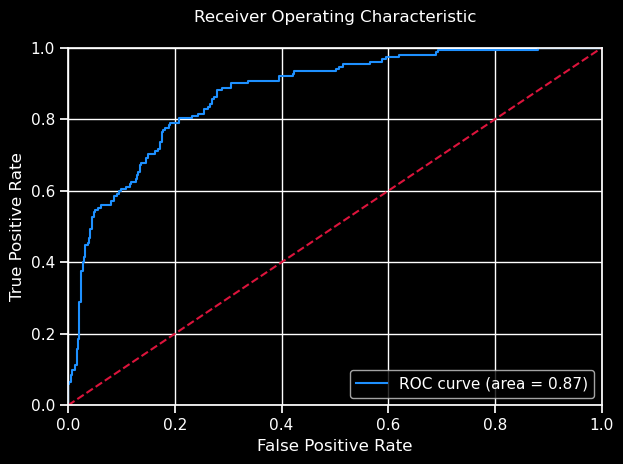

In [16]:
# Curva ROC con el modelo de línea base
roc_curve_plot(model)

### *Importancia de los Predictores*

* La **importancia de los predictores** (también conocida como importancia de las variables) en un modelo de Machine Learning es una medida de la contribución de cada variable para explicar la varianza en los datos y predecir la variable objetivo. En otras palabras, la **importancia de los predictores** indica cuán relevantes son las variables para el modelo y cuán bien pueden explicar la variable objetivo.

* En un modelo de **Random Forest**, la **importancia de los predictores** se calcula a partir de la reducción de la impureza en los nodos de los árboles. La impureza se refiere a la mezcla de diferentes clases en un nodo, y la reducción de la impureza se logra al dividir los nodos en subconjuntos más homogéneos.

* La **importancia de los predictores** se calcula para cada variable del modelo, y se puede expresar como un porcentaje o una puntuación normalizada. Las variables que tienen una mayor importancia son las que contribuyen más a la reducción de la impureza y, por lo tanto, son más relevantes para el modelo.

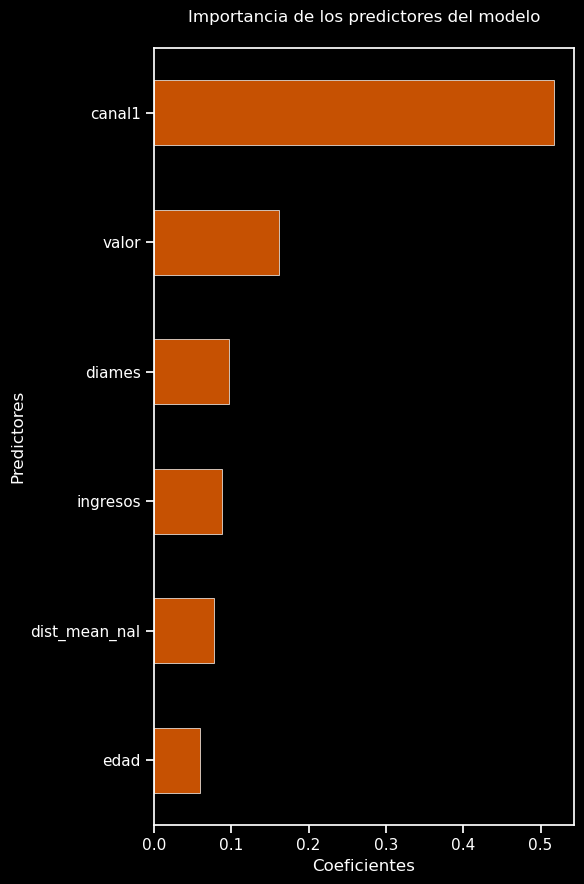

In [17]:
# Pesos de los coeficientes
coeficientes = dict(zip(model.feature_names_in_, [predictor for predictor in model.feature_importances_]))
coef_df = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['coeficientes'])
coef_df.sort_values('coeficientes', ascending=True, inplace=True)

# Graficar barras horizontales
coef_df.sort_values('coeficientes', ascending=True).plot.barh(figsize=(6, 9), color='xkcd:dark orange',  width=0.5,
                                                              edgecolor='white', lw=0.5, legend=False)

# Agregar etiquetas y títulos
plt.title('Importancia de los predictores del modelo\n')
plt.xlabel('Coeficientes')
plt.ylabel('Predictores')
plt.tight_layout()

In [18]:
# Predicciones del modelo
pd.DataFrame(model.predict_proba(X_val), columns=[0, 1], index=X_val.index).sample(10, random_state=777)

,0,1
id,,
7352997899,0.85,0.15
6771737346,0.74,0.26
7642897602,0.63,0.37
9000000341,0.63,0.37
7131642191,0.85,0.15
7563511817,0.17,0.83
4370564598,0.64,0.36
1145530828,0.43,0.57
9000000409,0.12,0.88


In [19]:
# Etiquetas reales
y_val.sample(10, random_state=777)

id
7352997899    0
6771737346    0
7642897602    1
9000000341    0
7131642191    0
7563511817    1
4370564598    0
1145530828    0
9000000409    1
728357205     0
Name: fraude, dtype: int64

### *Métricas de Evaluación*
* Las métricas de evaluación son medidas que se utilizan para evaluar el desempeño de un modelo de Machine Learning en una tarea específica, como la clasificación o la regresión. El reporte de clasificación es una de estas métricas y se utiliza específicamente para evaluar el desempeño de un modelo de clasificación.

* El reporte de clasificación es una tabla que muestra diversas métricas de evaluación para cada clase del modelo de clasificación. Algunas de las métricas que se incluyen en el reporte de clasificación son:

    * Precisión (precision): la proporción de predicciones positivas que son verdaderas positivas. En otras palabras, mide la exactitud de las predicciones positivas del modelo.

    * Recall (sensibilidad): la proporción de verdaderos positivos que fueron correctamente identificados por el modelo. En otras palabras, mide la capacidad del modelo para detectar todas las instancias positivas.

    * F1-score: una medida de la media armónica entre la precisión y el recall. Es útil para encontrar un balance entre la precisión y el recall.

    * Support: el número de instancias en la clase correspondiente.

In [20]:
# Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       440
           1       0.62      0.69      0.65       152

    accuracy                           0.81       592
   macro avg       0.75      0.77      0.76       592
weighted avg       0.82      0.81      0.81       592



### *Brier Score Loss*

* El **Brier Score** es una medida de la calidad de las predicciones probabilísticas. El **Brier Score Loss**  es una medida de la precisión de un modelo de clasificación que emite predicciones como probabilidades.

* El **Brier Score Loss**  mide la discrepancia entre las probabilidades predichas por un modelo y las probabilidades verdaderas de los eventos observados. Cuanto menor sea el **Brier Score Loss**, mejor será el modelo en términos de precisión de las predicciones.

In [21]:
from sklearn.metrics import brier_score_loss

# Predecir probabilidades de clase para datos de prueba
y_pred = model.predict_proba(X_val)[:, 1]

# Métricas
print(f'ROC-AUC de {type(model).__name__}: {100*roc_auc_score(y_val, y_pred):0.2f}%')
print(f'Brier Score de {type(model).__name__}: {100*brier_score_loss(y_val, y_pred):0.2f}%')

ROC-AUC de RandomForestClassifier: 87.18%
Brier Score de RandomForestClassifier: 14.58%


### *Calibrar*

* Calibrar las probabilidades de un modelo es importante para asegurarse de que las predicciones probabilísticas sean precisas y confiables. Un modelo bien calibrado es aquel en el que las probabilidades predichas se corresponden de manera precisa con la frecuencia con la que los eventos reales ocurren.

* La calibración de las probabilidades es especialmente importante en los modelos de clasificación que emiten probabilidades en lugar de predicciones discretas. Estos modelos suelen ser utilizados en tareas en las que es importante conocer la probabilidad de que ocurra un evento, como en la clasificación binaria o en la detección de anomalías.

* Si las probabilidades predichas no están calibradas correctamente, pueden surgir problemas como la sobreestimación o la subestimación de la probabilidad de ocurrencia de un evento. Por ejemplo, si un modelo de clasificación binaria predice una probabilidad del 90% de que un evento ocurra, pero en realidad ocurre solo el 50% de las veces, el modelo está sobrestimando la probabilidad.

In [22]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(model, cv=skfold, method='isotonic', n_jobs=-1)
calibrated_model.fit(X_val, y_val)
calibrated_probs = calibrated_model.predict_proba(X_val)[:, 1]

In [23]:
# Brier score del modelo calibrado
print(f'ROC-AUC de {type(calibrated_model).__name__}: {100*roc_auc_score(y_val, calibrated_probs):0.2f}%')
print(f'Brier Score de {type(calibrated_model).__name__}: {100*brier_score_loss(y_val, calibrated_probs):0.2f}%')

ROC-AUC de CalibratedClassifierCV: 91.91%
Brier Score de CalibratedClassifierCV: 9.79%


### *Curva de Calibración*
* La curva de calibración es una gráfica que muestra la relación entre las probabilidades predichas por el modelo y las frecuencias observadas de la clase positiva. Para crear la curva de calibración, se divide el conjunto de datos en un conjunto de entrenamiento y un conjunto de validación. Luego, el modelo se entrena en el conjunto de entrenamiento y se predice la probabilidad de la clase positiva en el conjunto de validación.

    Después, se agrupan las predicciones en diferentes intervalos de probabilidad y se calcula la frecuencia observada de la clase positiva dentro de cada intervalo. La curva de calibración se traza utilizando estos intervalos y la probabilidad media dentro de cada intervalo.

* Idealmente, si un modelo es completamente calibrado, la curva de calibración debería seguir una línea diagonal, lo que indica que las probabilidades predichas por el modelo se corresponden con las frecuencias observadas. Sin embargo, en la práctica, los modelos de clasificación suelen tener problemas de calibración, lo que puede resultar en una curva de calibración que no sigue una línea diagonal.

In [24]:
# Curva de calibración
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, probs, bins, model):

    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probs, n_bins=bins, 
                                                                    strategy='uniform')
    max_val = max(mean_predicted_value)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label=type(model).__name__, 
             c='limegreen')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
             linestyle='--', color='crimson', label='Perfect calibration')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve\n')
    plt.legend(loc='upper left')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=False, stacked=True, alpha=0.3, 
             color='xkcd:dark cyan', edgecolor='white', lw=0.5)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density\n')
    plt.grid()
    plt.tight_layout()


### *Analizar*

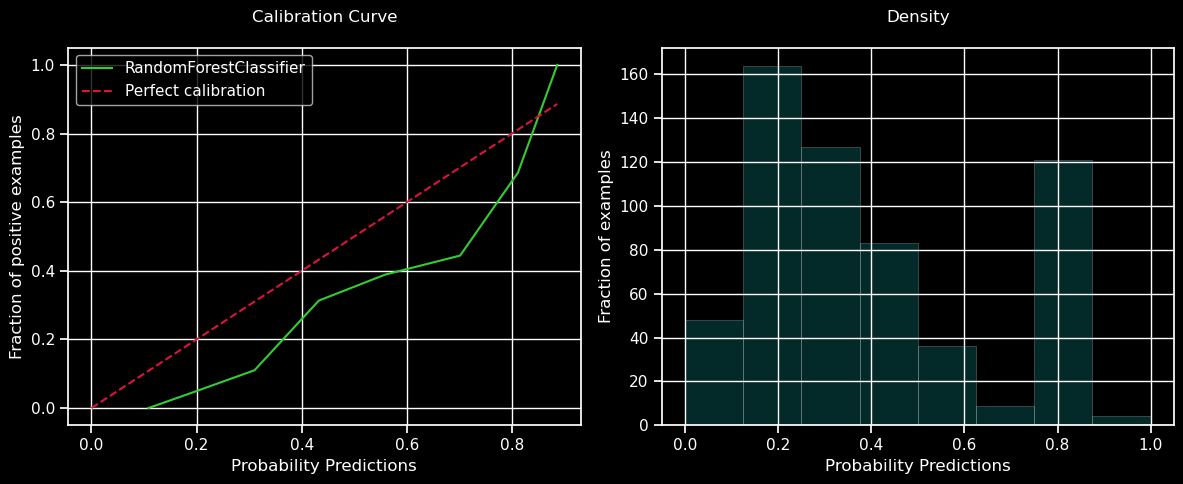

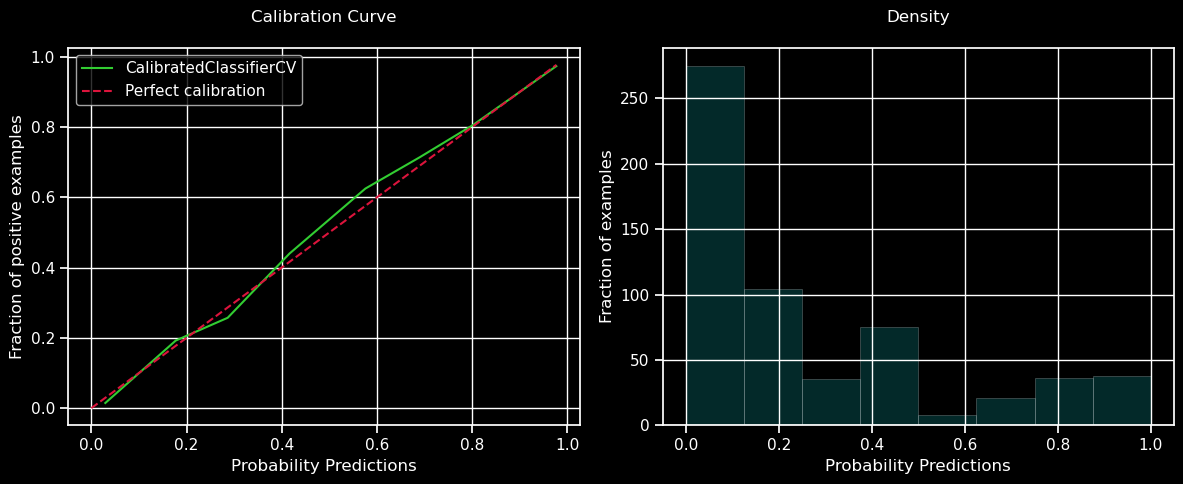

In [25]:
# A nivel visual los resultados
for modelo, probs in zip([model, calibrated_model], [y_pred, calibrated_probs]):
    plot_calibration_curve(y_val, probs, bins=8, model=modelo)

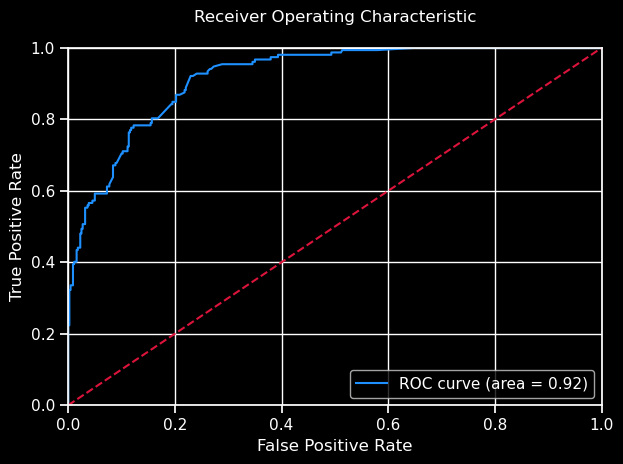

In [26]:
# Resultados con el modelo calibrado
roc_curve_plot(calibrated_model)

In [27]:
# Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_val, calibrated_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       440
           1       0.83      0.57      0.67       152

    accuracy                           0.86       592
   macro avg       0.85      0.76      0.79       592
weighted avg       0.86      0.86      0.85       592



### *Predicciones*
* Las predicciones finales de un modelo son las estimaciones o predicciones que hace el modelo sobre nuevos datos o datos no vistos previamente. Estas predicciones se generan una vez que el modelo ha sido entrenado con un conjunto de datos de entrenamiento y ha sido ajustado a los datos de validación y/o prueba para mejorar su precisión.

* El objetivo de un modelo de Machine Learning es generalizar su capacidad para predecir nuevos datos, no solo ajustarse bien a los datos de entrenamiento. Por lo tanto, las predicciones finales son importantes ya que permiten evaluar la capacidad del modelo para generalizar y hacer predicciones precisas sobre nuevos datos.

* En general, para generar predicciones finales, se proporciona al modelo un conjunto de datos de entrada y el modelo aplica sus algoritmos de aprendizaje para predecir la salida correspondiente. Por ejemplo, en un modelo de clasificación, se proporciona un conjunto de características y el modelo utiliza estas características para predecir la clase a la que pertenece el dato de entrada.

In [28]:
# Predicciones con el conjunto de test
pred_final = calibrated_model.predict_proba(test)
pred_final = pd.DataFrame(pred_final, columns=[0, 1], index=test.index)
pred_final = pred_final.reset_index()
pred_final

,id,0,1
0,98523068,1.00,0.00
1,300237898,0.81,0.19
2,943273308,0.31,0.69
3,951645809,0.58,0.42
4,963797516,0.52,0.48
...,...,...,...
95,9970518152,0.83,0.17
96,9971748725,1.00,0.00
97,9979565282,0.98,0.02
98,9979718478,0.57,0.43


### *Exportar*

In [29]:
import os

try:
    # Obtener la ruta actual del directorio de trabajo
    ruta_actual = os.getcwd()

    # Obtener el directorio padre de la ruta actual
    directorio_padre = os.path.dirname(ruta_actual)

    # Concatenar el nombre de la carpeta "datasets" al directorio padre
    ruta_datasets = os.path.join(directorio_padre, 'datasets')

    # Concatenar el nombre de la carpeta "resultados" a la ruta "ruta_datasets"
    path = os.path.join(ruta_datasets, 'resultados')

    # Crear la carpeta "resultados" en la ruta "path". El argumento exist_ok=True le indica a Python que no genere un error si la carpeta ya existe
    os.makedirs(path, exist_ok=True)

    # Exportar los resultados
    pred_final.to_csv(f'{path}\predicciones.csv', index=False)
    
except Exception as e:
        print(type(e).__name__)
        
finally:
    print('¡Realizado exitosamente!')

¡Realizado exitosamente!


---
---